# Behavioral vs Neural Timescale Sweep 

Taking both the behavioral and neural timescales to be normally distributed, we run a sweep over different behavioral and neural timescale standard deviations.

## Set up

In [6]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/timescales/timescales
Directory added to path:  /home/facosta/timescales
Directory added to path:  /home/facosta/timescales/timescales


In [10]:
from pathlib import Path

sweep_dir = Path(
    "/home/facosta/timescales/timescales/logs/experiments/heterogeneity_sweep_20260101_091059"
)
os.path.exists(sweep_dir)

True

In [11]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Grid parameters (from sweep config)
neural_stds = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
behav_stds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]


def load_experiment_data(sweep_dir, neural_std, behav_std, seed=0):
    """Load training losses and decoding errors for a single experiment."""
    exp_name = f"neural_std_{neural_std}_behav_std_{behav_std}"
    exp_path = sweep_dir / exp_name / f"seed_{seed}"

    # Load training losses
    with open(exp_path / "training_losses.json") as f:
        losses = json.load(f)

    # Load decoding errors
    with open(exp_path / "position_decoding_errors.json") as f:
        errors = json.load(f)

    return {
        "epochs": np.array(losses["epochs"]),
        "train_loss": np.array(losses["train_losses_epoch"]),
        "val_loss": np.array(losses["val_losses_epoch"]),
        "decoding_error": np.array(errors["position_errors_epoch"]),
    }


# Load all experiments
data = {}
for ns in neural_stds:
    for bs in behav_stds:
        data[(ns, bs)] = load_experiment_data(sweep_dir, ns, bs)


# === Plotting functions ===
def plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key,
    ylabel,
    title,
    log_x=False,
    log_y=False,
    figsize=(14, 12),
):
    """
    Create a 5x5 grid of plots.

    Rows: behavioral timescale std (increasing downward)
    Cols: neural timescale std (increasing rightward)
    """
    fig, axes = plt.subplots(5, 5, figsize=figsize, sharex=True, sharey=True)

    for i, bs in enumerate(behav_stds):
        for j, ns in enumerate(neural_stds):
            ax = axes[i, j]
            d = data[(ns, bs)]

            ax.plot(d["epochs"], d[metric_key], linewidth=1.5)

            if log_x:
                ax.set_xscale("log")
            if log_y:
                ax.set_yscale("log")

            # Title only on top row
            if i == 0:
                ax.set_title(f"τ_n std={ns}", fontsize=9)

            # Y-label only on left column
            if j == 0:
                ax.set_ylabel(f"τ_b std={bs}\n{ylabel}", fontsize=8)

            # X-label only on bottom row
            if i == len(behav_stds) - 1:
                ax.set_xlabel("Epoch", fontsize=8)

            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=7)

    fig.suptitle(title, fontsize=14, y=1.01)
    plt.tight_layout()
    return fig, axes

ValueError: x and y must have same first dimension, but have shapes (100,) and (99,)

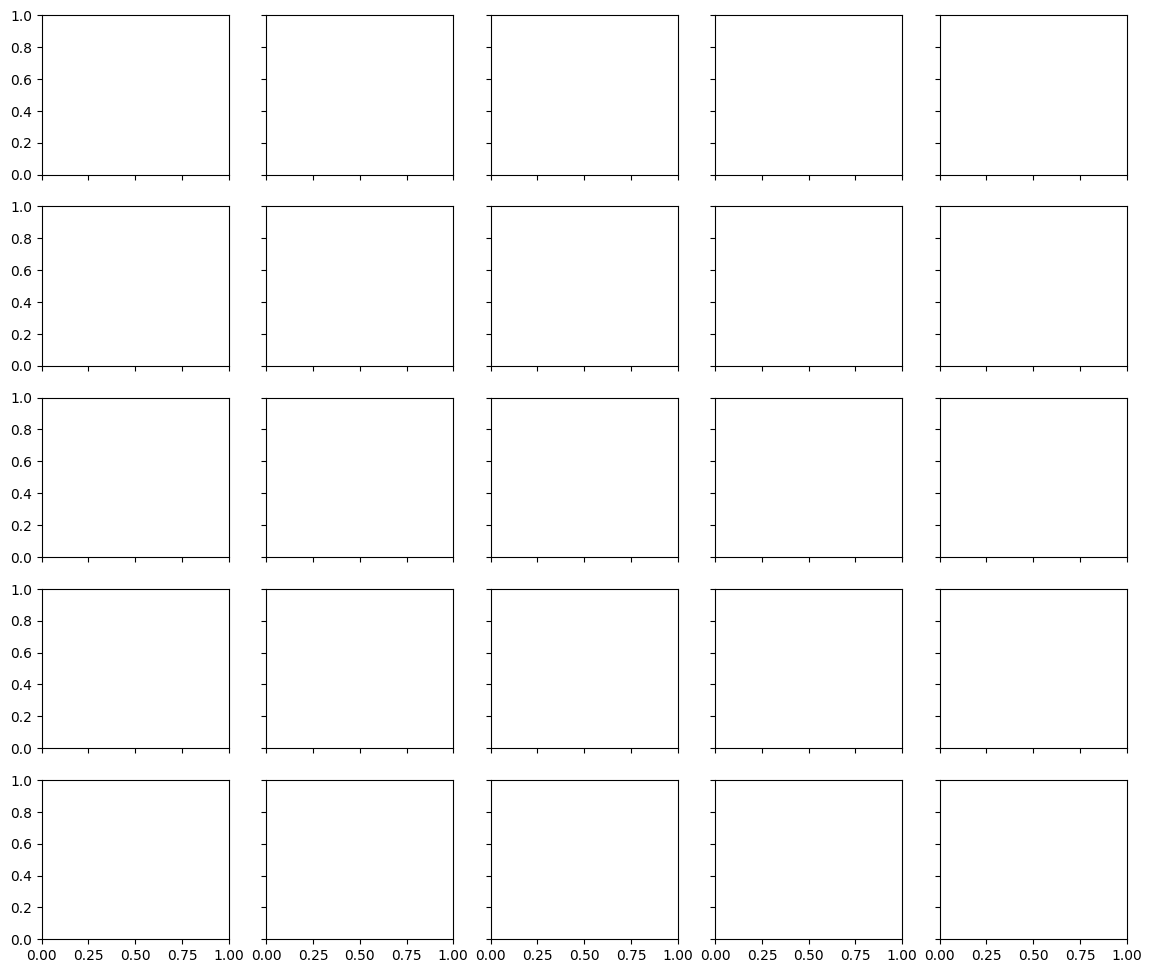

In [12]:
# 1. Training loss
fig1, _ = plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key="train_loss",
    ylabel="Train Loss",
    title="Training Loss vs Epoch (Neural τ_std → | Behavioral τ_std ↓)",
    log_x=False,
    log_y=False,
)
plt.show()

IndexError: index 5 is out of bounds for axis 1 with size 5

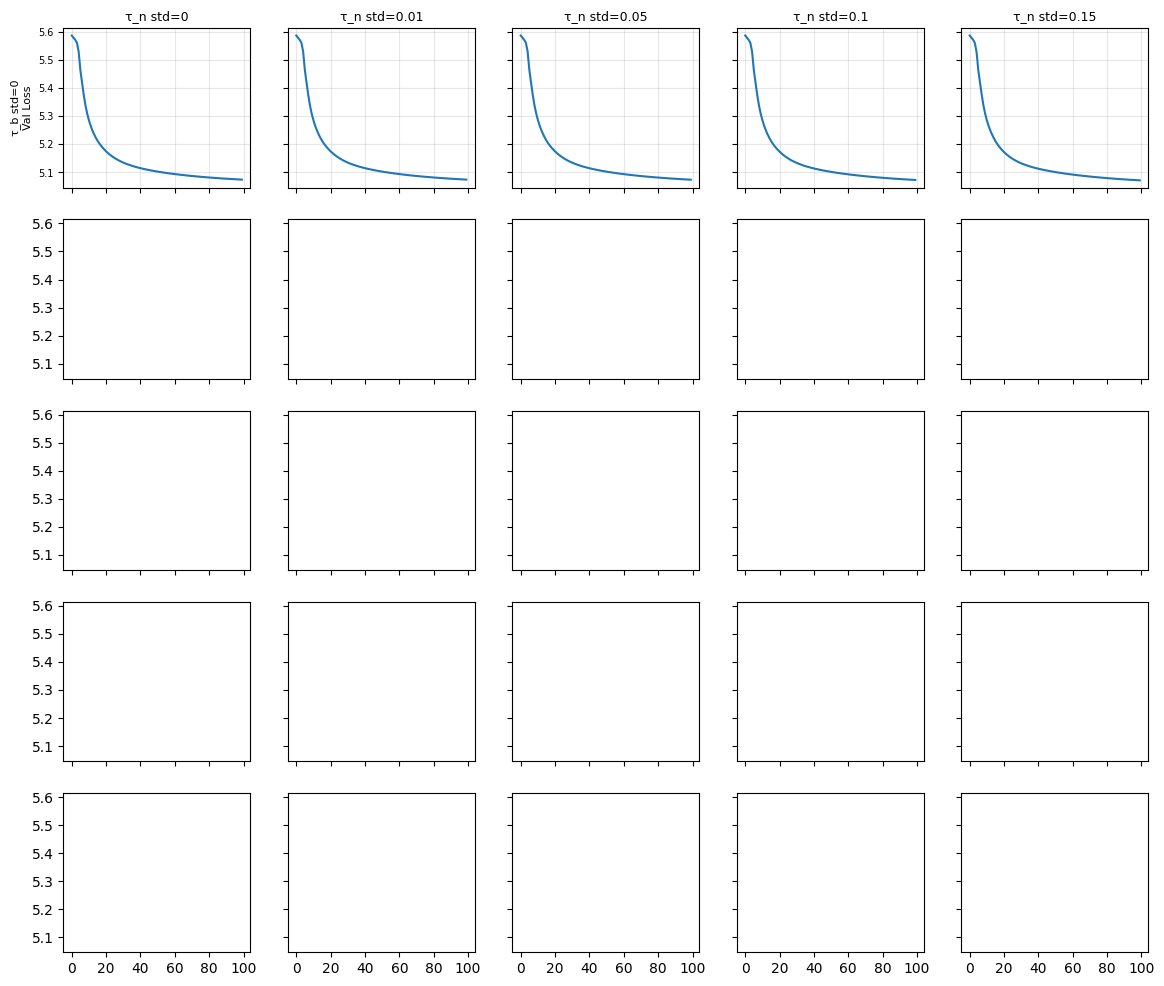

In [13]:
# 2. Validation loss
fig2, _ = plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key="val_loss",
    ylabel="Val Loss",
    title="Validation Loss vs Epoch (Neural τ_std → | Behavioral τ_std ↓)",
    log_x=False,
    log_y=False,
)
plt.show()

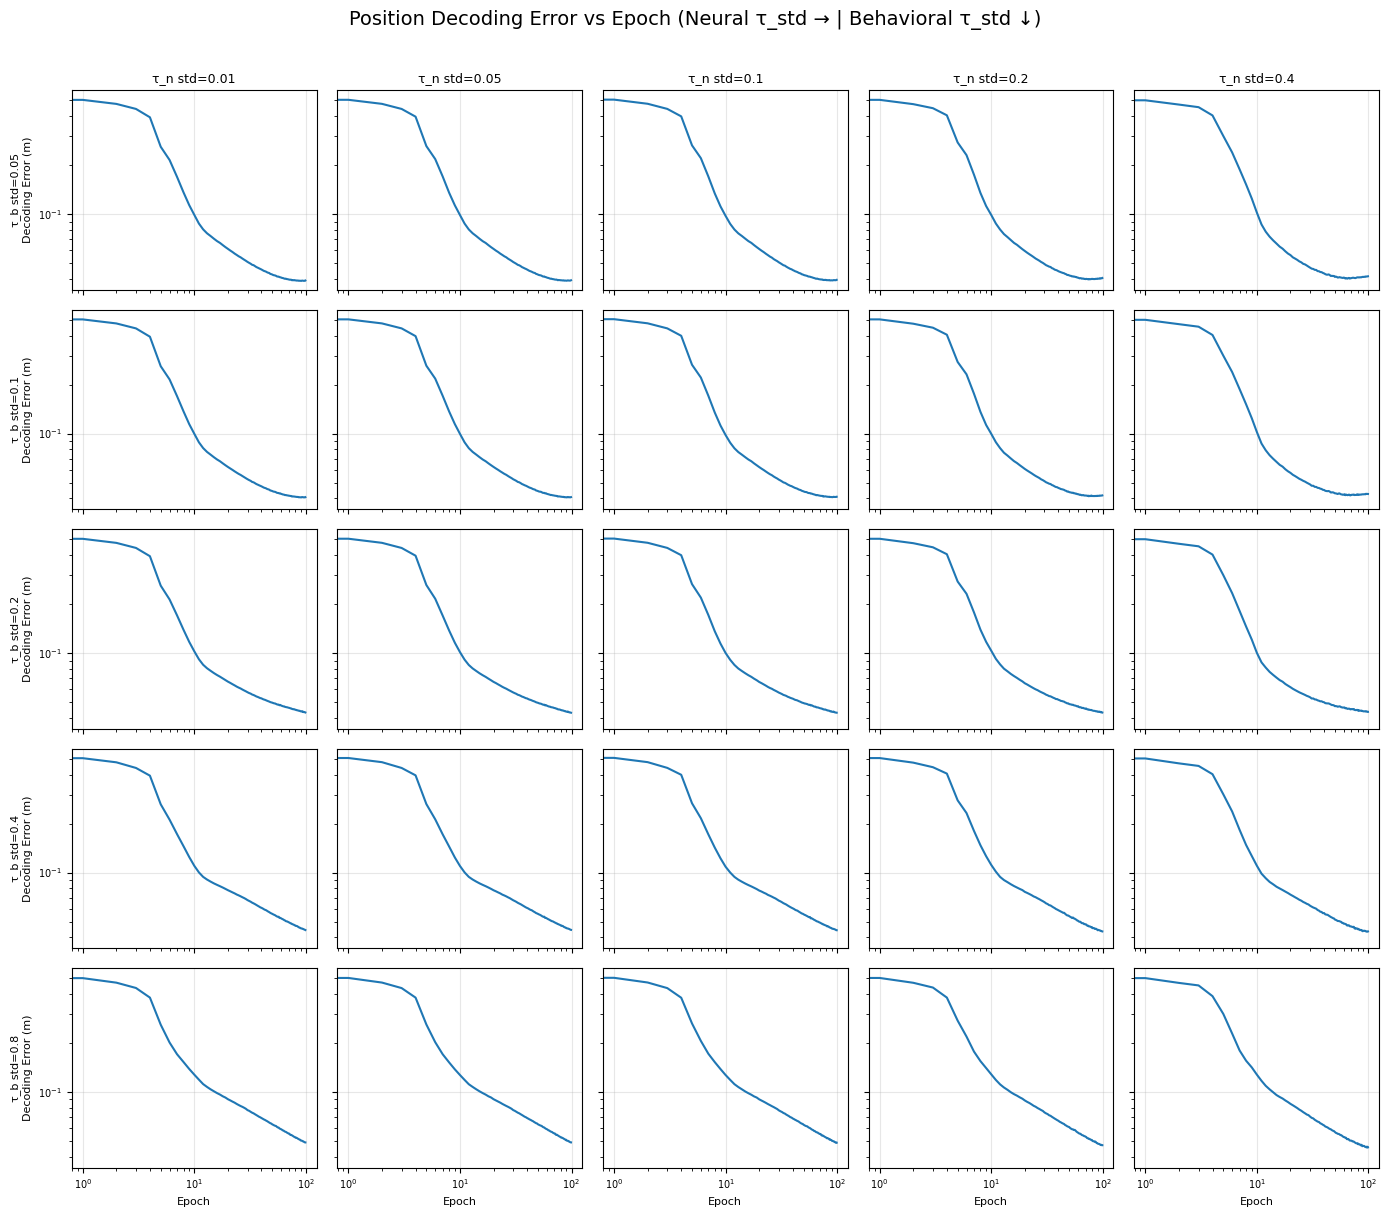

In [ ]:
# 3. Decoding error
fig3, _ = plot_5x5_grid(
    data,
    neural_stds,
    behav_stds,
    metric_key="decoding_error",
    ylabel="Decoding Error (m)",
    title="Position Decoding Error vs Epoch (Neural τ_std → | Behavioral τ_std ↓)",
    log_x=True,
    log_y=True,
)
plt.show()

In [4]:
import torch

def compute_target_entropy(exp_dir: Path, n_grid_points: int = 50):
    """Compute average target entropy over a grid of positions."""
    seed_dir = exp_dir / "seed_0"
    
    # Load place cell centers
    centers = torch.load(seed_dir / "place_cell_centers_seed0.pt")  # (N_pc, 2)
    
    # Load config for other params
    with open(seed_dir / "config_seed0.yaml") as f:
        cfg = yaml.safe_load(f)
    
    rf = cfg["place_cell_rf"]
    arena_size = cfg["arena_size"]
    DoG = cfg["DoG"]
    surround_scale = cfg["surround_scale"]
    
    # Create grid of positions spanning arena
    R = arena_size / 2
    xs = torch.linspace(-R, R, n_grid_points)
    ys = torch.linspace(-R, R, n_grid_points)
    xx, yy = torch.meshgrid(xs, ys, indexing='ij')
    positions = torch.stack([xx.flatten(), yy.flatten()], dim=-1)  # (N_pos, 2)
    
    # Compute place cell activations for each position
    # pos: (N_pos, 2), centers: (N_pc, 2)
    d2 = ((positions[:, None, :] - centers[None, :, :]) ** 2).sum(-1)  # (N_pos, N_pc)
    
    activations = torch.softmax(-d2 / (2 * rf**2), dim=-1)
    
    if DoG:
        surround = torch.softmax(-d2 / (2 * surround_scale * rf**2), dim=-1)
        activations = activations - surround
        activations = activations - activations.min(dim=-1, keepdim=True).values
        activations = activations / activations.sum(dim=-1, keepdim=True)
    
    # Compute entropy for each position, then average
    entropy = -(activations * torch.log(activations + 1e-8)).sum(-1)  # (N_pos,)
    
    return entropy.mean().item()

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Grid parameters
# neural_stds = [0, 0.01, 0.05, 0.1, 0.15 0.2, 0.4]
# behav_stds = [0.05, 0.1, 0.2, 0.4, 0.8]

neural_stds = [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
behav_stds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.8]


def load_final_metrics(sweep_dir, neural_stds, behav_stds, seed=0, subtract_entropy=False):
    """Load final values for all experiments into 2D arrays.
    
    Args:
        sweep_dir: Path to sweep directory
        neural_stds: List of neural timescale std values
        behav_stds: List of behavioral timescale std values
        seed: Random seed (default 0)
        subtract_entropy: If True, subtract target entropy from losses to get KL divergence
    
    Returns:
        final_train_loss, final_val_loss, final_decoding_error (as KL if subtract_entropy=True)
    """
    n_neural = len(neural_stds)
    n_behav = len(behav_stds)

    final_train_loss = np.zeros((n_neural, n_behav))
    final_val_loss = np.zeros((n_neural, n_behav))
    final_decoding_error = np.zeros((n_neural, n_behav))
    target_entropies = np.zeros((n_neural, n_behav))  # For diagnostics

    for i, ns in enumerate(neural_stds):
        for j, bs in enumerate(behav_stds):
            exp_name = f"neural_std_{ns}_behav_std_{bs}"
            exp_path = sweep_dir / exp_name / f"seed_{seed}"

            with open(exp_path / "training_losses.json") as f:
                losses = json.load(f)
            with open(exp_path / "position_decoding_errors.json") as f:
                errors = json.load(f)

            train_loss = losses["train_losses_epoch"][-1]
            val_loss = losses["val_losses_epoch"][-1]
            
            if subtract_entropy:
                # Compute target entropy for this experiment
                H = compute_target_entropy(sweep_dir / exp_name)
                target_entropies[i, j] = H
                train_loss -= H
                val_loss -= H
            
            final_train_loss[i, j] = train_loss
            final_val_loss[i, j] = val_loss
            final_decoding_error[i, j] = errors["position_errors_epoch"][-1]

    if subtract_entropy:
        print(f"Target entropy range: {target_entropies.min():.4f} - {target_entropies.max():.4f}")
    
    return final_train_loss, final_val_loss, final_decoding_error


# Load all final metrics
final_train, final_val, final_error = load_final_metrics(
    sweep_dir, neural_stds, behav_stds, subtract_entropy=True
)


def plot_heatmap(
    matrix,
    neural_stds,
    behav_stds,
    title,
    cbar_label,
    cmap="viridis",
    figsize=(8, 6),
    annot=True,
    fmt=".3f",
):
    """
    Plot a heatmap with behavioral τ_std on x-axis and neural τ_std on y-axis.
    """
    fig, ax = plt.subplots(figsize=figsize)

    im = ax.imshow(matrix, cmap=cmap, aspect="auto", origin="lower")

    # Set tick labels
    ax.set_xticks(np.arange(len(behav_stds)))
    ax.set_xticklabels([str(b) for b in behav_stds])
    ax.set_yticks(np.arange(len(neural_stds)))
    ax.set_yticklabels([str(n) for n in neural_stds])

    ax.set_xlabel("Behavioral Timescale Std (s)", fontsize=12)
    ax.set_ylabel("Neural Timescale Std (s)", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)

    # Annotate cells with values
    if annot:
        for i in range(len(neural_stds)):
            for j in range(len(behav_stds)):
                text = ax.text(
                    j,
                    i,
                    f"{matrix[i, j]:{fmt}}",
                    ha="center",
                    va="center",
                    fontsize=8,
                    color="white" if matrix[i, j] < matrix.mean() else "black",
                )

    plt.tight_layout()
    return fig, ax

Target entropy range: 5.0259 - 5.0259


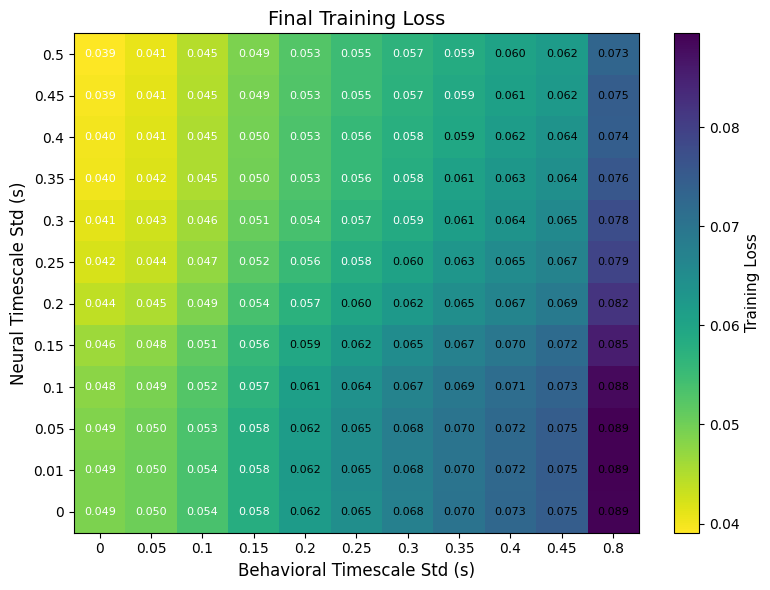

In [6]:
# 1. Final Training Loss
fig1, _ = plot_heatmap(
    final_train,
    neural_stds,
    behav_stds,
    title="Final Training Loss",
    cbar_label="Training Loss",
    cmap="viridis_r",  # reversed so lower = better = darker
)
plt.show()

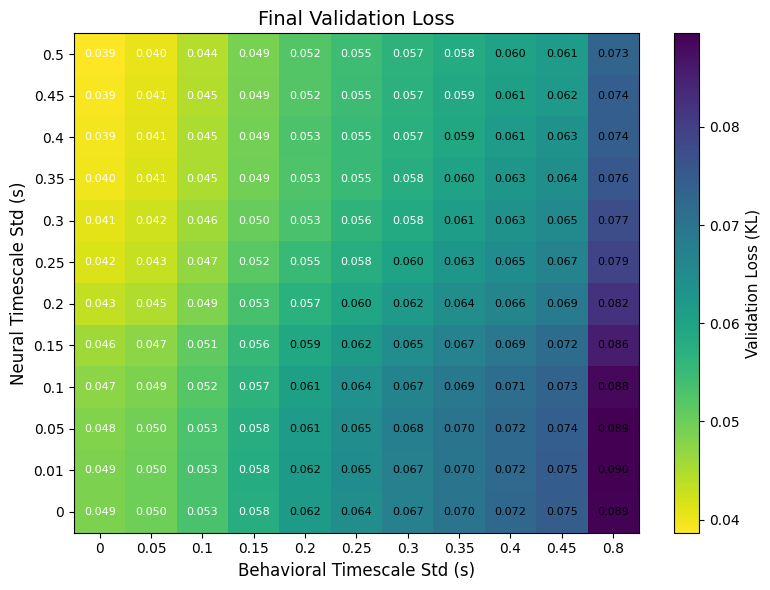

In [9]:
# 2. Final Validation Loss
fig2, _ = plot_heatmap(
    final_val,
    neural_stds,
    behav_stds,
    title="Final Validation Loss",
    cbar_label="Validation Loss (KL)",
    cmap="viridis_r",
)
plt.show()

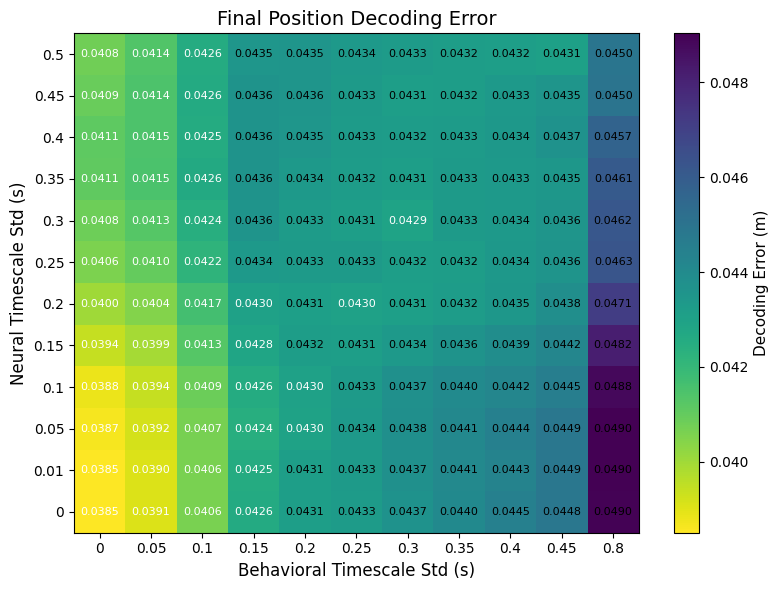

In [8]:
# 3. Final Decoding Error
fig3, _ = plot_heatmap(
    final_error,
    neural_stds,
    behav_stds,
    title="Final Position Decoding Error",
    cbar_label="Decoding Error (m)",
    cmap="viridis_r",
    fmt=".4f",  # more precision for small errors
)
plt.show()

In [1]:
# Subtract the target place cell distribution entropy
# H(P,Q) = H(P) + D_{KL}(P||Q)

# this gives us the KL divergence of the target distribution from the model distribution